In [1]:
import json
from tqdm import tqdm
import re
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
from transformers import *
logging.set_verbosity_error()
from tokenizers import BertWordPieceTokenizer
import os
from sklearn.model_selection import train_test_split
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, early_stop
import tensorflow_addons as tfa

C:\Users\soymi\anaconda3\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [2]:
data_file = 'arxiv-metadata-oai-snapshot.json'

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line
            
metadata = get_metadata()
titles = []
categories = []
for paper in metadata:
    paper_dict = json.loads(paper)
    titles.append(paper_dict.get('title'))
    categories.append(paper_dict.get('categories'))

In [3]:
print(len(titles))
print(len(categories))

1955945
1955945


<h3>굉장히 커서 다루기힘든수준임</h3>
30000개도 4 epochs에 30분정도걸렸는데 이정도면 사실상 1주일은돌려야함 -> 최신논문들로 짜름

In [4]:
titles = []
categories = []
years = []
refs = []
abstracts = []
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
    ref = paper_dict.get('journal-ref')
    try:
        year = int(re.findall(r'\((.*?)\)', ref)[0][-4:])
        if 2018 <= year <= 2021:
            years.append(year)
            refs.append(ref)
            titles.append(paper_dict.get('title'))
            categories.append(paper_dict.get('categories'))
            abstracts.append(paper_dict.get('abstract'))
    except:
        pass

In [5]:
print(len(titles))
print(len(categories))

122767
122767


In [6]:
def get_major(x):
    temp_ = [z.split('.')[0] for z in x.split(' ')]
    return '/'.join(list(set(temp_)))

In [7]:
major_topic = list(map(get_major, categories))

In [8]:
res = pd.DataFrame({'title' : titles, 'major_topic' : major_topic, 'year' : years, 'abstract' : abstracts})

In [9]:
res

title        major_topic  \
0       Sobolev regularity of solutions of the cohomol...               math   
1       Bohmian Mechanics at Space-Time Singularities....           quant-ph   
2       What happens to geometric phase when spin-orbi...           cond-mat   
3              Reentrant spin glass transition in LuFe2O4           cond-mat   
4               On finiteness of odd superperfect numbers               math   
...                                                   ...                ...   
122762  An explicit zero-free region for the Dirichlet...               math   
122763  Diophantine approximation on planar curves: th...               math   
122764   True and fake Lax pairs: how to distinguish them  math-ph/nlin/math   
122765                              Free Will and Physics            physics   
122766  Large Numbers, the Chinese Remainder Theorem, ...           quant-ph   

        year                                           abstract  
0       2021    We refine the theory of the cohomological eq...  
1       2019    We develop an extension of Bohmian mechanics...  
2       2018    Spin-orbit interaction lifts accidental band...  
3       2020    We have carried out a comprehensive investig...  
4       2020    Some new results concerning the equation $\s...  
...      ...                                                ...  
122762  2018    Let $L(s,\chi)$ be the Dirichlet $L$-functio...  
122763  2019    The convergence theory for the set of simult...  
122764  2020    The gauge-invariant description of zero-curv...  
122765  2018    The abstract concept of indeterministic free...  
122766  2020    This is a pedagogical article cited in the f...  

[122767 rows x 4 columns]

In [48]:
joblib.dump(res, 'data.pickle')

['data.pickle']

In [2]:
train_data = joblib.load('data.pickle')

In [3]:
train_data

title        major_topic  \
0       Sobolev regularity of solutions of the cohomol...               math   
1       Bohmian Mechanics at Space-Time Singularities....           quant-ph   
2       What happens to geometric phase when spin-orbi...           cond-mat   
3              Reentrant spin glass transition in LuFe2O4           cond-mat   
4               On finiteness of odd superperfect numbers               math   
...                                                   ...                ...   
122762  An explicit zero-free region for the Dirichlet...               math   
122763  Diophantine approximation on planar curves: th...               math   
122764   True and fake Lax pairs: how to distinguish them  math-ph/nlin/math   
122765                              Free Will and Physics            physics   
122766  Large Numbers, the Chinese Remainder Theorem, ...           quant-ph   

        year                                           abstract  
0       2021    We refine the theory of the cohomological eq...  
1       2019    We develop an extension of Bohmian mechanics...  
2       2018    Spin-orbit interaction lifts accidental band...  
3       2020    We have carried out a comprehensive investig...  
4       2020    Some new results concerning the equation $\s...  
...      ...                                                ...  
122762  2018    Let $L(s,\chi)$ be the Dirichlet $L$-functio...  
122763  2019    The convergence theory for the set of simult...  
122764  2020    The gauge-invariant description of zero-curv...  
122765  2018    The abstract concept of indeterministic free...  
122766  2020    This is a pedagogical article cited in the f...  

[122767 rows x 4 columns]

<h1>데이터 구성 완료</h1>  

<h3>인공지능(예측)</h3>  
1.title로 major_topic 예측하기  

2.abstract로 title 예측하기  

<h3>데이터분석(시각화, EDA)</h3>  

1.year별로 major_topic 등장횟수 시각화  
2.major_topic별로자주 등장하는 단어 확인 + LDA로 주제 파악해보기  
3.year별로 자주 등장하는 단어 확인  
4.title의 word_embedding 방식을 바꿔보며 시각화해보기(BOW, TF-IDF, Word2Vec, fastText, glove, BERT)


<h3>학습을위해 title을 전처리함</h3>

In [2]:
train_data = joblib.load('data.pickle')
def title_preprocessing(X):
    X = re.sub(r'\$(.*?)\$', '', X)
    X = re.sub(r'\n', ' ', X)
    return X.strip()

X = train_data['title'].apply(title_preprocessing)

In [3]:
y = train_data['major_topic'].str.get_dummies('/')
joblib.dump(y, 'model1_target.pickle')

['model1_target.pickle']

<ipython-input-4-a3ba7c75fc73>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(y.sum(axis = 0).sort_values(ascending=False).keys(), fontsize = 20, rotation = -45)


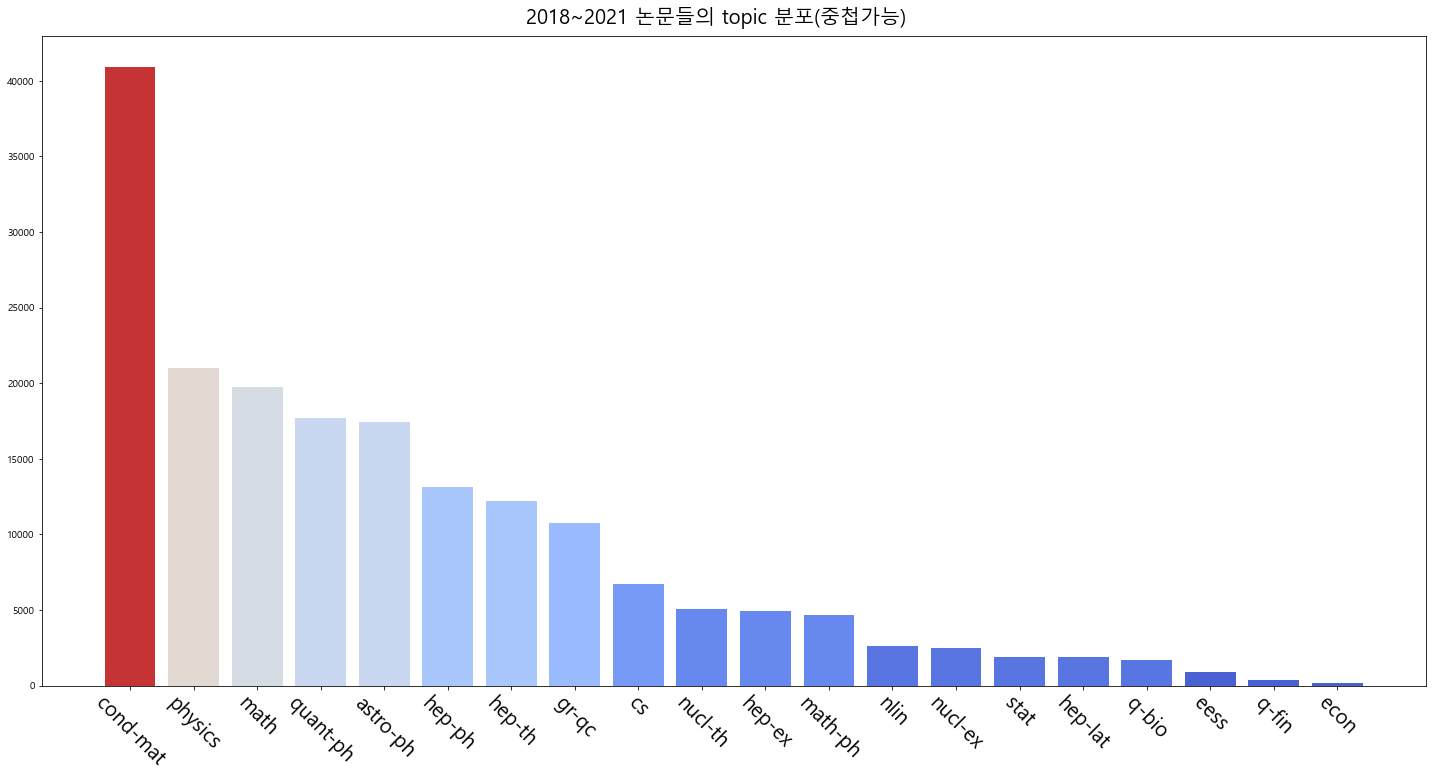

In [4]:
v = y.sum(axis = 0).sort_values(ascending=False).values

def color_from_values(v, p):
    normalized = (v - min(v)) / (max(v) - min(v))
    indices = np.round(normalized * (len(v) - 1)).astype(np.int64)
    palette = sns.color_palette(p, len(v))
    return np.array(palette).take(indices, axis = 0)
pal = color_from_values(v, 'coolwarm')

fig, ax = plt.subplots(figsize = (20, 10))
ax.bar(y.sum(axis = 0).sort_values(ascending=False).keys(), v, color = pal)
plt.suptitle('2018~2021 논문들의 topic 분포(중첩가능)', fontsize = 20)
plt.tight_layout()
ax.set_xticklabels(y.sum(axis = 0).sort_values(ascending=False).keys(), fontsize = 20, rotation = -45)


plt.show()

Unbalance가 심함. -> Focal loss

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True, stratify=y['econ'], random_state=42)

In [6]:
len(X_train)

98213

In [7]:
tokenizer =  BertTokenizer.from_pretrained("bert-base-uncased", lowercase=True)
def check_max_length(X):
    a = [len(tokenizer.encode(x, add_special_tokens=True)) for x in X]
    return max(a)

In [8]:
check_max_length(X)

133

128로 사용할것임

In [9]:
class string_to_input(object):
    def __init__(self, max_length:int):
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", lowercase=True)
        self.max_length = max_length
    
    def convert(self,X):
        temp_token = list(map(self.get_token_emb, X))
        token_embedding = np.array(list(map(self.pad, temp_token)))
        segment_embedding = self.get_segment(token_embedding)
        attention_mask = self.get_mask(token_embedding)
        return [token_embedding, attention_mask, segment_embedding]
        
    def get_token_emb(self, X):
        return self.tokenizer.encode(X, add_special_tokens=True, max_length=self.max_length, truncation=True)
    
    def pad(self, X):
        if len(X) == self.max_length:
            return X
        else:
            return X + [0] * (self.max_length - len(X))
            
    def get_mask(self, X):
        return np.where(X == 0, 0, 1)
    
    def get_segment(self, X):
        return np.zeros(X.shape)

In [10]:
converter = string_to_input(128)
X_train, X_test = converter.convert(X_train), converter.convert(X_test)

In [11]:
X_train[0].shape

(98213, 128)

In [12]:
n_label = len(y.columns)

In [13]:
del(X)
del(y)
del(train_data)

In [21]:
def return_model(params):
    eta = np.power(10., -params['eta'])
    n_nodes = np.power(2., params['n_nodes'])
    tf.random.set_seed(42)
    
    model = TFBertModel.from_pretrained('bert-base-uncased', from_pt=True)
    token_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_word_ids')
    mask_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_masks')
    segment_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_segment')
    bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
    fc = tf.keras.layers.BatchNormalization()(bert_outputs[1])
    for _ in range(params['n_layers']):
        fc = tf.keras.layers.Dense(n_nodes, activation = tfa.activations.gelu if params['activation'] == 'gelu' else tfa.activations.mish,
                                  kernel_initializer = tf.keras.initializers.he_normal(seed=42))(fc)
        fc = tf.keras.layers.Dropout(rate = params['dropout'])(fc)
        fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Dense(n_label, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.he_normal(seed = 42))(fc)
    classficiation_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], fc)
    
    if params['optimizer'] == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
    elif params['optimizer'] == 'nadam':
        opt = tf.keras.optimizers.Nadam(learning_rate=eta)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=eta)
    classficiation_model.layers[3].layers[0].trainable = False
    classficiation_model.compile(optimizer=opt, loss = tfa.losses.focal_loss.SigmoidFocalCrossEntropy(), metrics=['accuracy'])
    return classficiation_model
    
ss = {'n_layers' : 3,
        'n_nodes' : 5,
        'eta' : 2,
        'optimizer' : 'nadam', #beta 1, 2, epsilon은 안건드릴예정
        'dropout' : .15,
        'activation' : 'mish'}
model  = return_model(ss)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_segment (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_2 (TFBertModel)   TFBaseModelOutputWit 109482240   input_word_ids[0][0]             
                                                                 input_masks[0][0]          

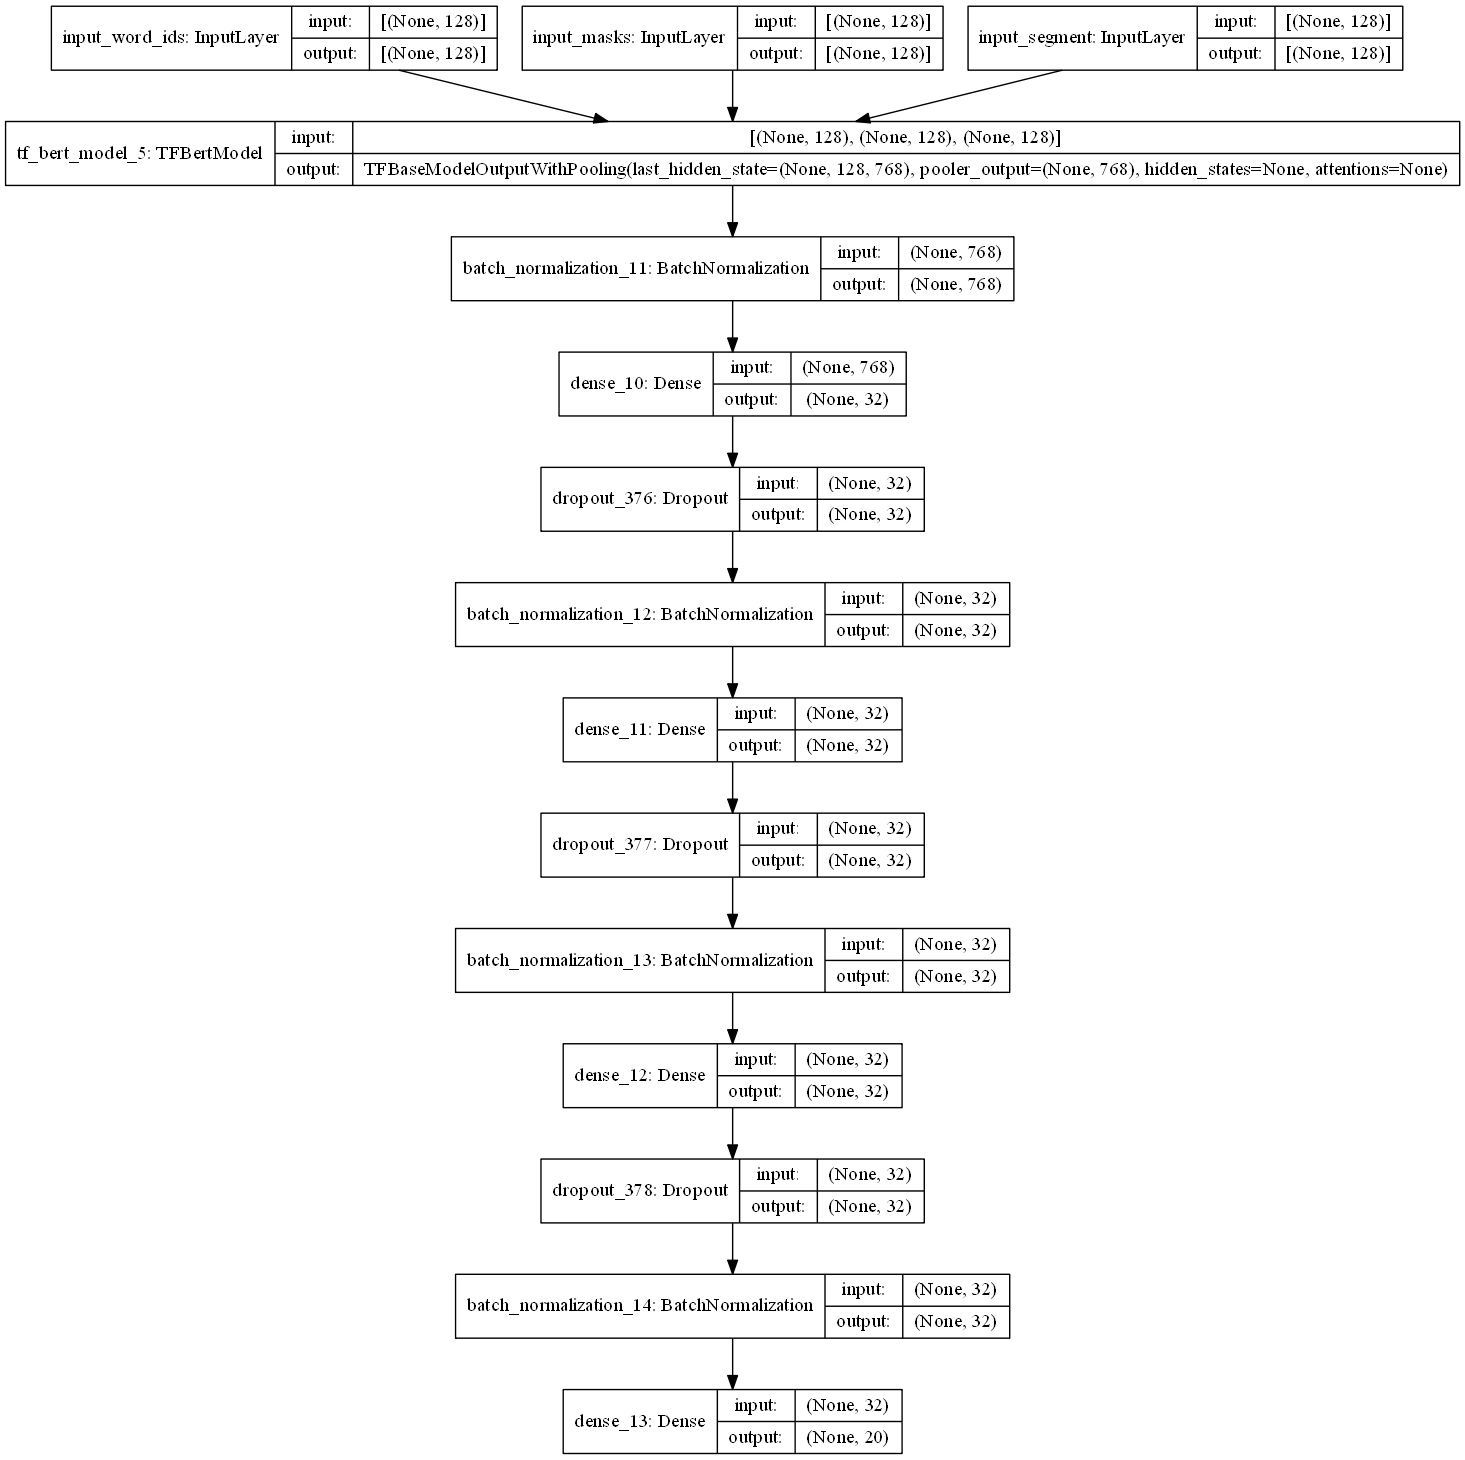

In [29]:
tf.keras.utils.plot_model(model, to_file='model1_example.png', show_shapes=True, show_layer_names=True, dpi=100)

<h3>기반은 다 만들었으니 학습시작</h3>

In [14]:
def search_space():
    search_space = {
        'n_nodes' : hp.quniform('n_nodes', 5, 9, 1),
        'n_layers' : hp.quniform('n_layers', 0, 5, 1),
        'eta' : hp.quniform('eta', 1, 4, 1),
        'optimizer' : hp.choice('optimizer', ['adam','nadam','rmsprop']), #beta 1, 2, epsilon은 안건드릴예정
        'dropout' : hp.uniform('dropout', 0., .2),
        'activation' : hp.choice('activation', ['gelu','mish'])
}
    
    return search_space

def return_model(params):
    eta = np.power(10., -params['eta'])
    tf.random.set_seed(42)
    n_nodes = np.power(2., params['n_nodes'])
    
    model = TFBertModel.from_pretrained('bert-base-uncased', from_pt=True)
    token_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_word_ids')
    mask_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_masks')
    segment_inputs = tf.keras.layers.Input((128,), dtype=tf.int32, name='input_segment')
    bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
    fc = tf.keras.layers.BatchNormalization()(bert_outputs[1])
    for _ in range(int(params['n_layers'])):
        fc = tf.keras.layers.Dense(int(n_nodes), activation = tfa.activations.gelu if params['activation'] == 'gelu' else tfa.activations.mish,
                                  kernel_initializer = tf.keras.initializers.lecun_normal(seed=42))(fc)
        fc = tf.keras.layers.Dropout(rate = params['dropout'])(fc)
        fc = tf.keras.layers.BatchNormalization()(fc)
    fc = tf.keras.layers.Dense(n_label, activation = 'sigmoid', kernel_initializer = tf.keras.initializers.glorot_normal(seed = 42))(fc)
    classificiation_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], fc)
    
    if params['optimizer'] == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
    elif params['optimizer'] == 'nadam':
        opt = tf.keras.optimizers.Nadam(learning_rate=eta)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=eta)
    classificiation_model.layers[3].layers[0].trainable = False
    classificiation_model.compile(optimizer=opt, loss = tfa.losses.focal_loss.SigmoidFocalCrossEntropy(), metrics=['accuracy'])
    return classificiation_model
    
def objective(params):
    eta = np.power(10., -params['eta'])
    if params['optimizer'] == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=eta)
    elif params['optimizer'] == 'nadam':
        opt = tf.keras.optimizers.Nadam(learning_rate=eta)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=eta)
    
    model = return_model(params)
    early_stopping_monitor = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0,patience=10000,verbose=0,mode='auto',baseline=None,restore_best_weights=True)
    #12GB TitanX : 128lengthinput, 32batchsize
    hist = model.fit(X_train, y_train, epochs=6, shuffle=True, batch_size=32, validation_data=(X_test, y_test), verbose = 2, callbacks = [early_stopping_monitor])
#     model.layers[3].layers[0].trainable = True
#    opt.lr = opt.lr / 100.
#     model.compile(optimizer=opt, loss = tfa.losses.focal_loss.SigmoidFocalCrossEntropy(), metrics=['accuracy'])
#     model.fit(X_train, y_train, epochs=2, shuffle=True, batch_size=16, validation_data=(X_test, y_test), verbose = 2, callbacks = [early_stopping_monitor])
    score =(1 - max(hist.history['val_accuracy']))
    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(objective, search_space(), algo=tpe.suggest, max_evals=20, trials= trials, rstate = np.random.RandomState(42) )
joblib.dump(trials, 'model1_log.pickle')
joblib.dump(best, 'model1_besthp.pickle')

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:From C:\Users\soymi\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\array_ops.py:5043: calling gather (from tensorflow.python.ops.array_ops) with validate_indices is deprecated and will be removed in a future version.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/6                                                                                                              
3070/3070 - 368s - loss: 0.3805 - accuracy: 0.4822 - val_loss: 0.3126 - val_accuracy: 0.5527                           

Epoch 2/6                                                                                                              
3070/3070 - 362s - loss: 0.3351 - accuracy: 0.5195 - val_loss: 0.3153 - val_accuracy: 0.5667                           

Epoc

job exception: OOM when allocating tensor with shape[30522,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:AssignVariableOp]



 70%|████████████████████████████▋            | 14/20 [8:33:00<3:39:51, 2198.62s/trial, best loss: 0.39354074001312256]


ResourceExhaustedError: OOM when allocating tensor with shape[30522,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:AssignVariableOp]

In [18]:
trials.best_trial

{'state': 2,
 'tid': 7,
 'spec': None,
 'result': {'loss': 0.39354074001312256,
  'status': 'ok',
  'model': <tensorflow.python.keras.engine.functional.Functional at 0x1d15c110400>},
 'misc': {'tid': 7,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'activation': [7],
   'dropout': [7],
   'eta': [7],
   'n_layers': [7],
   'n_nodes': [7],
   'optimizer': [7]},
  'vals': {'activation': [0],
   'dropout': [0.13454398005101037],
   'eta': [2.0],
   'n_layers': [2.0],
   'n_nodes': [7.0],
   'optimizer': [2]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2021, 10, 16, 7, 4, 38, 20000),
 'refresh_time': datetime.datetime(2021, 10, 16, 7, 40, 33, 134000)}

<h3>일단 나중에 더해볼것임</h3>  
1.pre-trained를 풀면 예측력이 급감함 -> why? focal loss때문에 loss가 튄다? 아님스케쥴러 사용?radam?

2.너무 무거움 -> Dataset을 좀 줄여볼수도?

<h3> 초록으로 표제 예측 </h3>  
BART를 사용할것임. 컴퓨터에 가해지는 부담 + 더 나은 결과를 위해 논문 수가 가장 많은 cond-mat category의 논문들만 사용할것.

<h3>year별로 major_topic 등장횟수 시각화</h3>

In [3]:
data_file = 'arxiv-metadata-oai-snapshot.json'

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line
            
titles = []
categories = []
years = []
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
    ref = paper_dict.get('journal-ref')
    try:
        year = int(re.findall(r'\((.*?)\)', ref)[0][-4:])
        if 2001 <= year <= 2020:
            years.append(year)
            titles.append(paper_dict.get('title'))
            categories.append(paper_dict.get('categories'))
    except:
        pass
    
def get_major(x):
    temp_ = [z.split('.')[0] for z in x.split(' ')]
    return '/'.join(list(set(temp_)))
major_topic = list(map(get_major, categories))
res = pd.DataFrame({'title' : titles, 'major_topic' : major_topic, 'year' : years})
def title_preprocessing(X):
    X = re.sub(r'\$(.*?)\$', '', X)
    X = re.sub(r'\n', ' ', X)
    return X.strip()
res.title = res.title.apply(title_preprocessing)
joblib.dump(res,'forvis_01_20.pickle')
del(res)

In [ ]:
vis = joblib.load('forvis_01_20.pickle')
vis = vis.loc[:, ['major_topic', 'year']]

In [96]:
categories = vis.major_topic.str.get_dummies('/')
categories['year'] = vis['year']
categories = categories.loc[:, ['year'] + [x for x in categories.columns if x != 'year']]
res = categories.groupby('year').sum().T
res = res.loc[res.sum(axis = 1) > 300,:]

In [110]:
res.index[0]

'astro-ph'

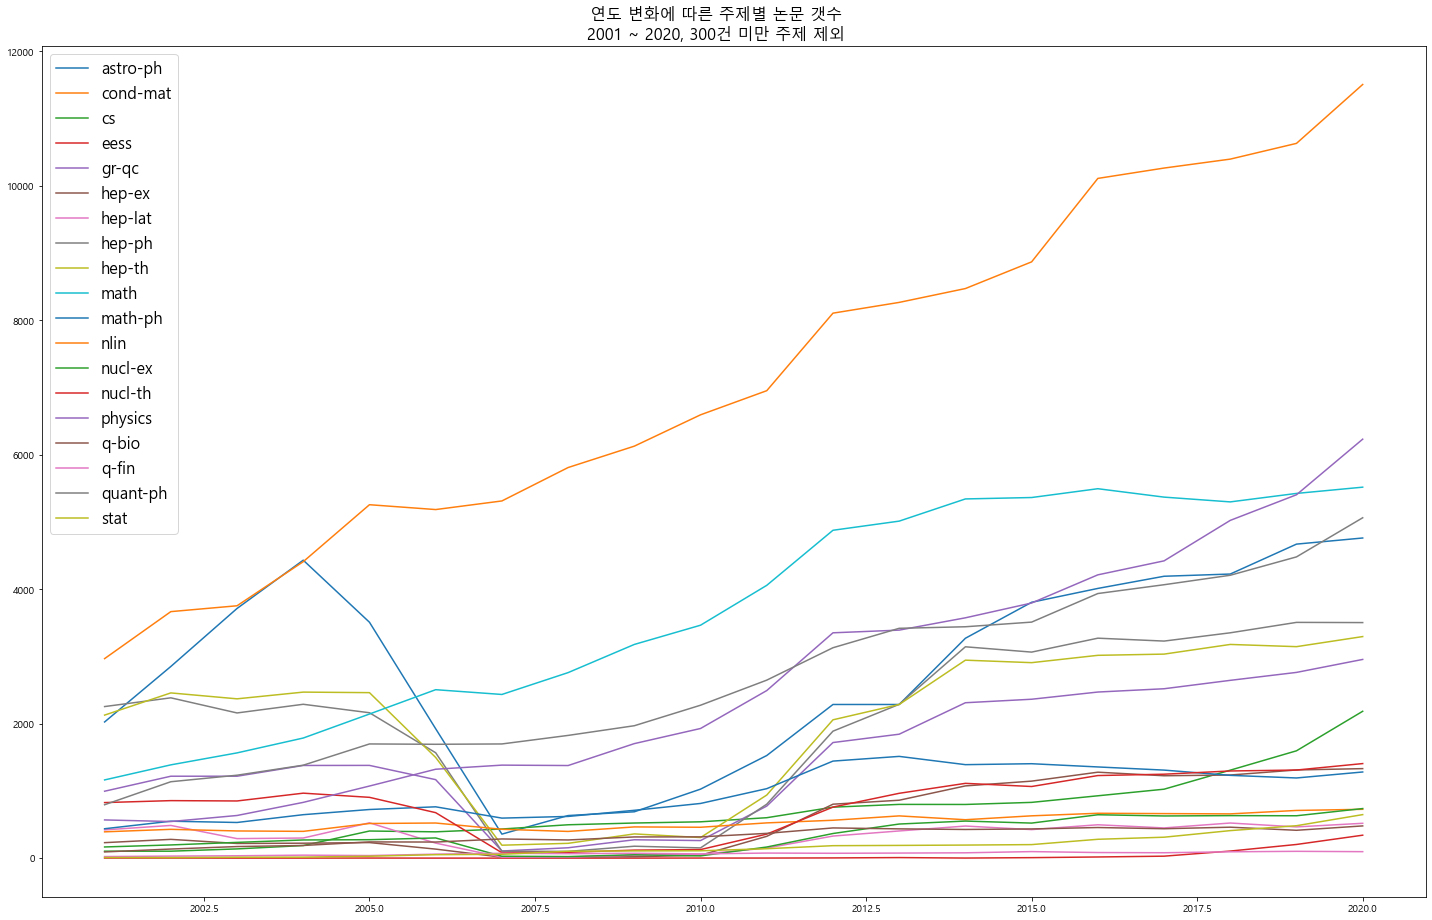

In [117]:
fig, ax = plt.subplots(figsize = (20, 13))
for i in range(len(res)):
    ax.plot(res.iloc[i,], label = res.index[i])
ax.legend(fontsize = 16)
fig.suptitle('연도 변화에 따른 주제별 논문 갯수\n2001 ~ 2020, 300건 미만 주제 제외',fontsize = 16)
plt.tight_layout()
plt.show()

<h3>year별로 자주 등장하는 단어 확인</h3>

In [62]:
vis = joblib.load('forvis_01_20.pickle')
vis = vis.loc[:,[x for x in vis.columns if x != 'major_topic']]
title = vis.title.str.lower()
title = title.apply(lambda x: nltk.word_tokenize(x))
title = title.apply(lambda x: [word for word in x if word not in (stop_words)])
title = title.apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])
title = title.apply(lambda x: [word for word in x if len(word) > 3])
vis.title = [' '.join(x) for x in title]
del(title)
vis

title  year
0                                                  dyadic  2008
1       numerical solution shock ramp compression gene...  2008
2       approximation extinction probability contact p...  2007
3       molecular synchronization wave array allosteri...  2007
4       filling-factor-dependent magnetophonon resonan...  2007
...                                                   ...   ...
412854  discrete asymptotic w-congruences plucker line...  2001
412855                          aspects painleve analysis  2013
412856                  matrix integrals geometry spinors  2001
412857  average non-local hamiltonian structure whitha...  2002
412858                 quantum pair yang-baxter equations  2009

[412859 rows x 2 columns]

In [73]:
words = []

for year in vis.year.value_counts().sort_index().keys():
    temp_title = vis.loc[vis.year == year, ['title']]
    BOW_transformer = CountVectorizer(stop_words=stop_words).fit(temp_title['title'])
    res = BOW_transformer.transform(temp_title['title'])
    res = pd.DataFrame(res.toarray().astype('int8'))
    idx2 = np.argsort(-np.sum(res, axis = 0))[:25]
    print(idx2[0])
    res = [word for idx3 in idx2 for word, idx in BOW_transformer.vocabulary_.items() if idx == idx3]
    words.append(res)

4790
5450
6035
6628
8788
8455
7213
7742
8128
8545
9294
10512
10689
11438
11760
12418
12669
13136
13544
14090


In [74]:
df = pd.DataFrame(words).set_index(vis.year.value_counts().sort_index().keys())

subsets = pd.IndexSlice[(0,1), 'col1']
df.style.apply(lambda x: ["background: yellow" if v == 'network' else "" for v in x], axis = 1)

<h3>major_topic별로자주 등장하는 단어 확인</h3>

In [75]:
vis = joblib.load('forvis_01_20.pickle')
vis = vis.loc[:,[x for x in vis.columns if x != 'year']]
title = vis.title.str.lower()
title = title.apply(lambda x: nltk.word_tokenize(x))
title = title.apply(lambda x: [word for word in x if word not in (stop_words)])
title = title.apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])
title = title.apply(lambda x: [word for word in x if len(word) > 3])
vis.title = [' '.join(x) for x in title]
del(title)
vis

title  \
0                                                  dyadic   
1       numerical solution shock ramp compression gene...   
2       approximation extinction probability contact p...   
3       molecular synchronization wave array allosteri...   
4       filling-factor-dependent magnetophonon resonan...   
...                                                   ...   
412854  discrete asymptotic w-congruences plucker line...   
412855                          aspects painleve analysis   
412856                  matrix integrals geometry spinors   
412857  average non-local hamiltonian structure whitha...   
412858                 quantum pair yang-baxter equations   

                                       major_topic  
0                                             math  
1                                         cond-mat  
2                                             math  
3                               q-bio/nlin/physics  
4                                         cond-mat  
...                                            ...  
412854                          nlin/math/solv-int  
412855                  nlin/math-ph/math/solv-int  
412856  nlin/hep-th/solv-int/math/adap-org/math-ph  
412857                               nlin/solv-int  
412858                        nlin/hep-th/solv-int  

[412859 rows x 2 columns]

In [95]:
words = []

dummies = vis.major_topic.str.get_dummies('/')
for topic in dummies.columns:
    temp_title = vis.loc[dummies.loc[:,topic]== 1,['title']]
    BOW_transformer = CountVectorizer(stop_words=stop_words).fit(temp_title['title'])
    res = BOW_transformer.transform(temp_title['title'])
    res = pd.DataFrame(res.toarray().astype('int8'))
    idx2 = np.argsort(-np.sum(res, axis = 0))[:20]
    print(idx2[0])
    res = [word for idx3 in idx2 for word, idx in BOW_transformer.vocabulary_.items() if idx == idx3]
    words.append(res)

3
51
16866
54
20138
7352
20
421
950
0
800
1280
1664
5309
2972
7386
6010
3944
1048
3387
0
12197
0
4374
1368
8278
76
2586


In [103]:
df = pd.DataFrame(words).set_index(dummies.columns)

df.style.apply(lambda x: ['background: yellow' if x.name in ['math', 'cs', 'stat'] else '' for i in x], axis = 1)

<h3>LDA...?</h3>

<h3>title의 word_embedding 방식을 바꿔보며 시각화해보기(BOW, TF-IDF, Word2Vec, fastText, glove, BERT)</h3>

In [8]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import joblib
stop_words = set(stopwords.words('english'))
import umap
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib
from sklearn.metrics import silhouette_score

In [2]:
#시각화를위해 주제가 1개만것들만 골라옴
x = joblib.load('data.pickle')
vis2_label = x.major_topic.str.get_dummies('/')
x = x.loc[vis2_label.sum(axis = 1) == 1, :]

In [3]:
x = x.reset_index(drop = True)
x

title major_topic  year  \
0      Sobolev regularity of solutions of the cohomol...        math  2021   
1      Bohmian Mechanics at Space-Time Singularities....    quant-ph  2019   
2      What happens to geometric phase when spin-orbi...    cond-mat  2018   
3             Reentrant spin glass transition in LuFe2O4    cond-mat  2020   
4              On finiteness of odd superperfect numbers        math  2020   
...                                                  ...         ...   ...   
77782  Summation formulae for noncommutative hypergeo...        math  2018   
77783  An explicit zero-free region for the Dirichlet...        math  2018   
77784  Diophantine approximation on planar curves: th...        math  2019   
77785                              Free Will and Physics     physics  2018   
77786  Large Numbers, the Chinese Remainder Theorem, ...    quant-ph  2020   

                                                abstract  
0        We refine the theory of the cohomological eq...  
1        We develop an extension of Bohmian mechanics...  
2        Spin-orbit interaction lifts accidental band...  
3        We have carried out a comprehensive investig...  
4        Some new results concerning the equation $\s...  
...                                                  ...  
77782    We establish several summation formulae for ...  
77783    Let $L(s,\chi)$ be the Dirichlet $L$-functio...  
77784    The convergence theory for the set of simult...  
77785    The abstract concept of indeterministic free...  
77786    This is a pedagogical article cited in the f...  

[77787 rows x 4 columns]

In [4]:
#visualization을 더 좋게하기위해 상위10개만 가져옴
x = x.loc[x.major_topic.isin(x.major_topic.value_counts()[:10].keys()),:]

In [5]:
le = LabelEncoder()
labels = le.fit_transform(x.major_topic)

In [6]:
le.classes_

array(['astro-ph', 'cond-mat', 'cs', 'gr-qc', 'hep-ex', 'hep-ph',
       'hep-th', 'math', 'physics', 'quant-ph'], dtype=object)

In [7]:
Counter(labels)

Counter({7: 12348,
         9: 7042,
         1: 25643,
         8: 7840,
         3: 2542,
         0: 9861,
         2: 2573,
         5: 3634,
         6: 2006,
         4: 1194})

In [8]:
labels

array([7, 9, 1, ..., 7, 8, 9])

<h3>Preprocessing</h3>

In [9]:
title = x.title.str.lower()

title = title.apply(lambda x: nltk.word_tokenize(x))

title = title.apply(lambda x: [word for word in x if word not in (stop_words)])

title = title.apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])

title = title.apply(lambda x: [word for word in x if len(word) > 3])

title = [' '.join(x) for x in title]

<h3>BoW</h3>

In [10]:
BOW_transformer = CountVectorizer(stop_words=stop_words).fit(title)

In [11]:
BOW_transformer

CountVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [12]:
res = BOW_transformer.transform(title)
BOW_ev = res.toarray()

In [13]:
del(x)

<h3>UMAP을 쓰려했는데 메모리가 터져서 계속 커널이 죽음 -> TSNE사용</h3>  

autoencoder는 많이 써본적도 없고 최근 공부한 vae나 aae는 너무강력해서 오히려 차이를 확인할 수 없을 것 같음  

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [2:02:00<00:00, 1830.10s/it]


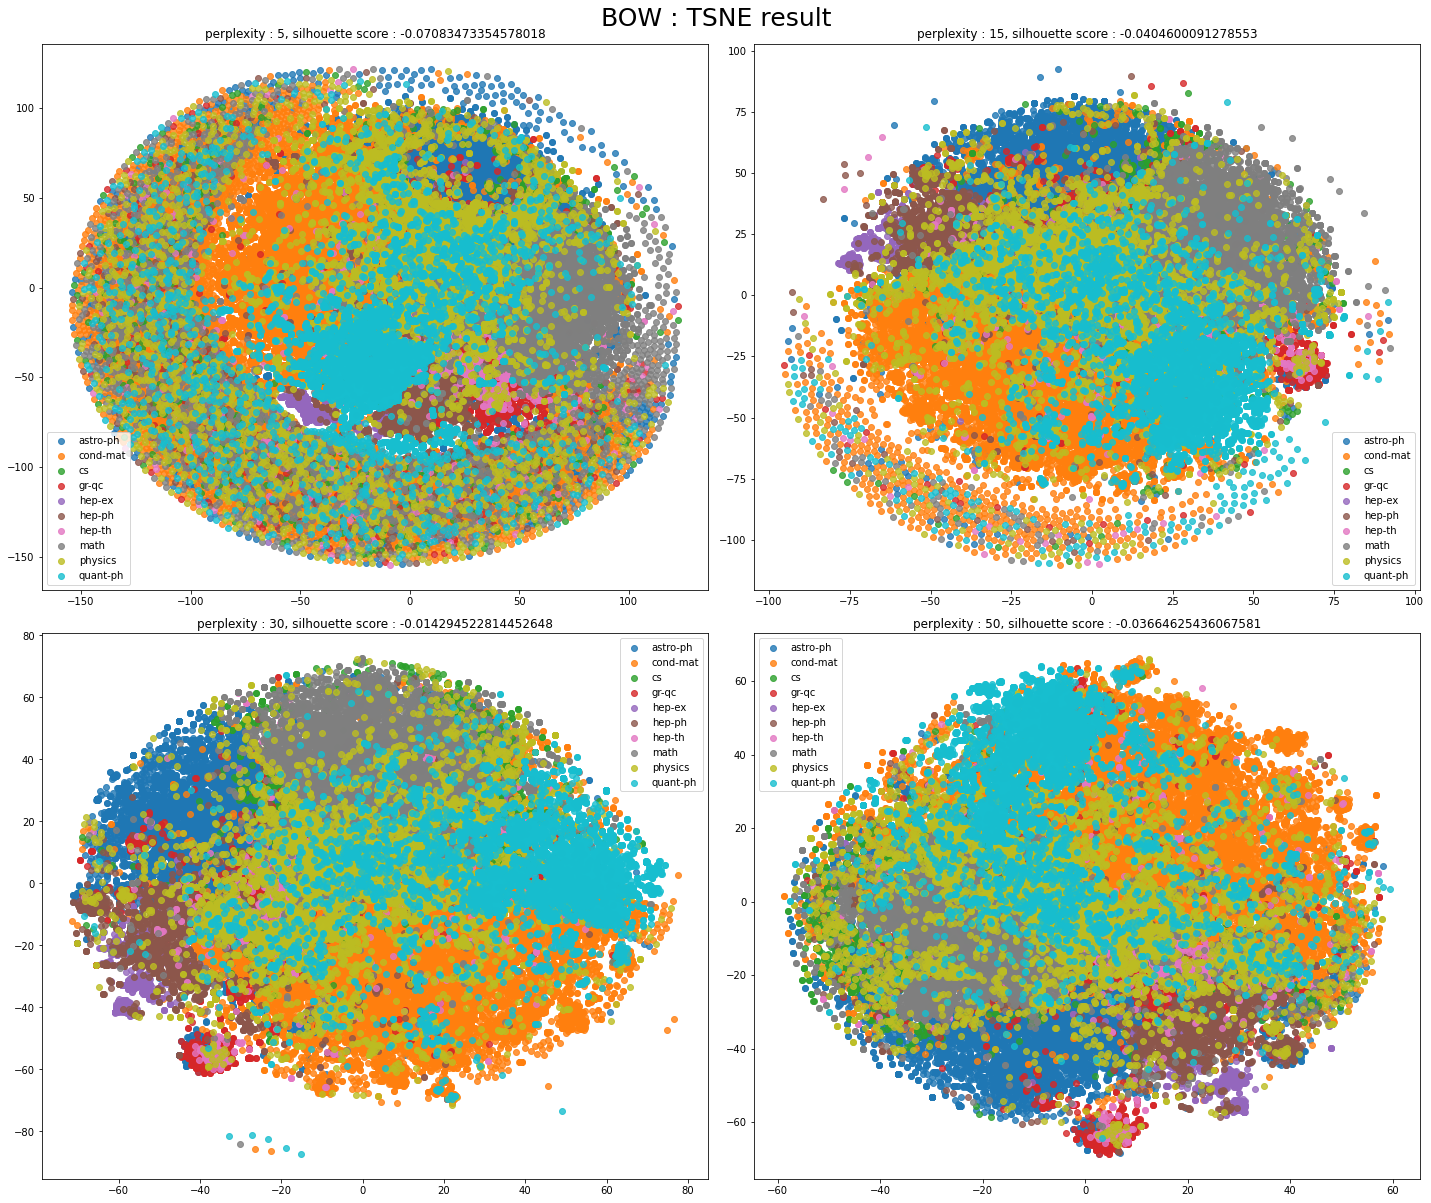

In [43]:
search_space = [5, 15, 30, 50]
fig, ax = plt.subplots(2,2, figsize = (20,17))

i = 0
for hp in tqdm(search_space):
    reduced = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 42, perplexity = hp).fit_transform(BOW_ev)
    for idx, c in enumerate(le.classes_):
        ax[i//2, i%2].scatter(reduced[labels == idx, 0], reduced[labels == idx, 1], label = c, color = plt.cm.tab10(idx), alpha = .8)
    ax[i//2, i%2].legend()
    ax[i//2, i%2].set_title(f'perplexity : {hp}, silhouette score : {silhouette_score(reduced, labels)}')
    i = i + 1
plt.suptitle('BOW : TSNE result', fontsize = 25)
plt.tight_layout()
plt.show()

<h3>TF-IDF</h3>

In [10]:
tfidf_transformer = TfidfVectorizer(stop_words=stop_words).fit(title)
tfidf_transformer

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [11]:
res = tfidf_transformer.transform(title)
tfidf_ev = res.toarray()

100%|████████████████████████████████████████████████████████████████████████████████| 4/4 [1:40:38<00:00, 1509.69s/it]


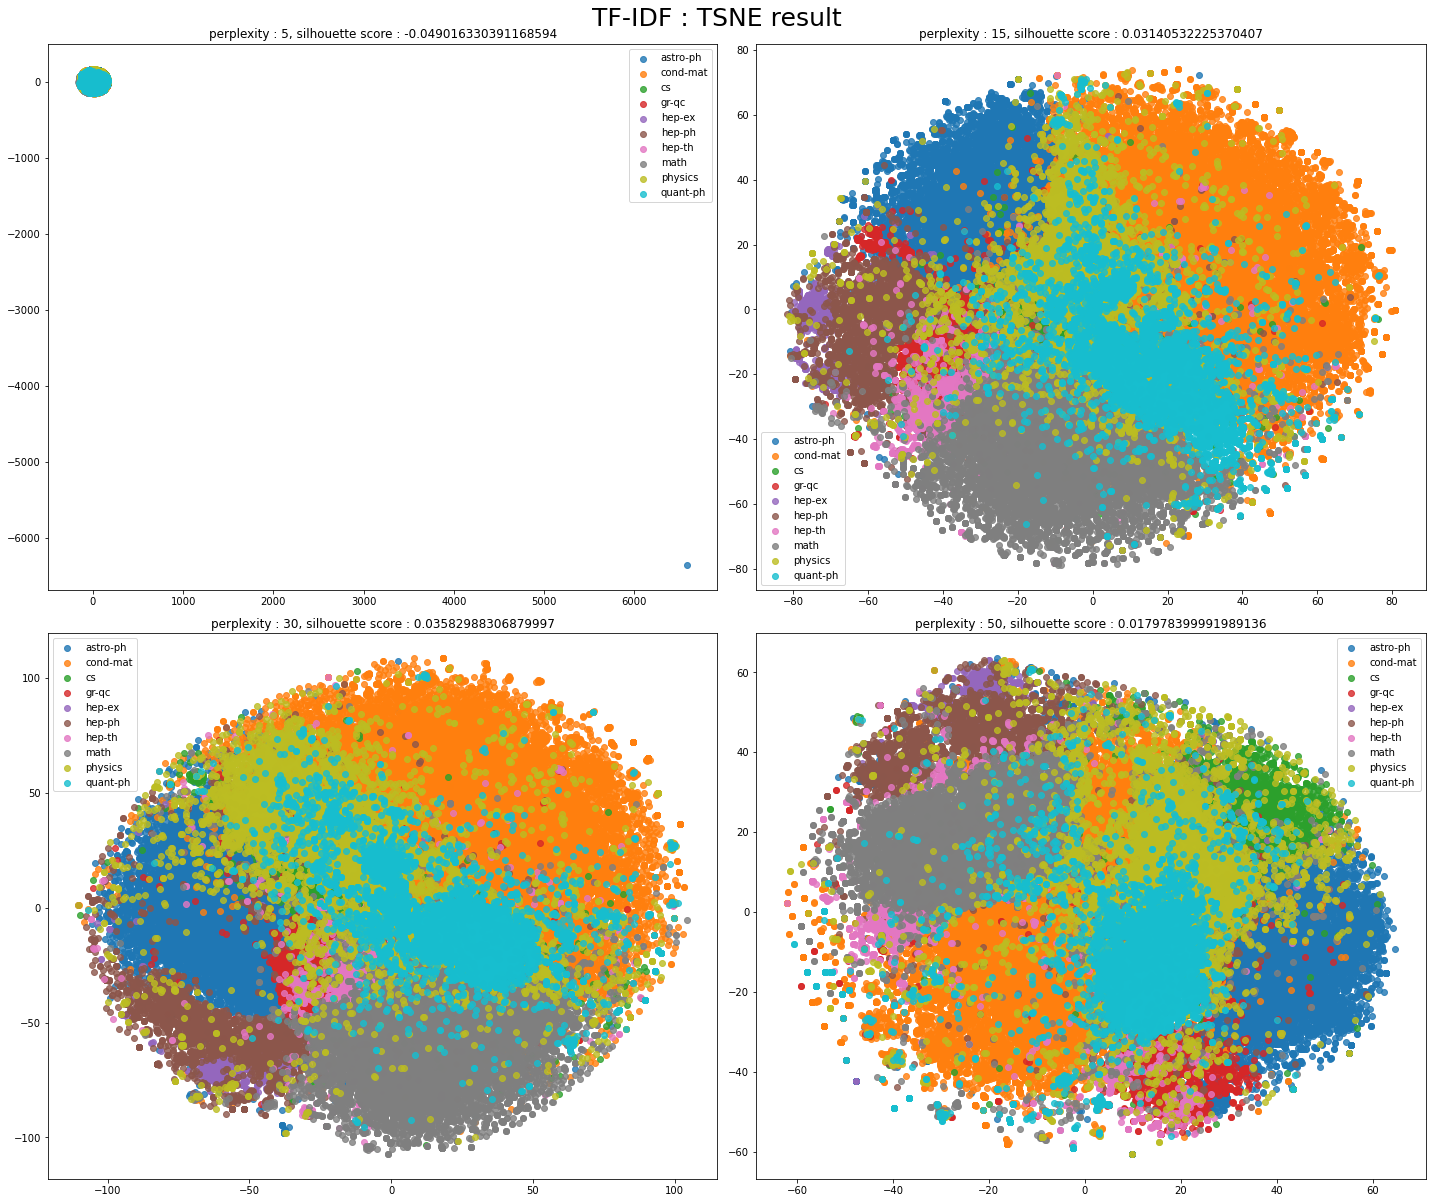

In [12]:
search_space = [5, 15, 30, 50]
fig, ax = plt.subplots(2,2, figsize = (20,17))

i = 0
for hp in tqdm(search_space):
    reduced = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 42, perplexity = hp).fit_transform(tfidf_ev)
    for idx, c in enumerate(le.classes_):
        ax[i//2, i%2].scatter(reduced[labels == idx, 0], reduced[labels == idx, 1], label = c, color = plt.cm.tab10(idx), alpha = .8)
    ax[i//2, i%2].legend()
    ax[i//2, i%2].set_title(f'perplexity : {hp}, silhouette score : {silhouette_score(reduced, labels)}')
    i = i + 1
plt.suptitle('TF-IDF : TSNE result', fontsize = 25)
plt.tight_layout()
plt.show()

<h3>W2V</h3>

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
import gensim

C:\Users\soymi\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [10]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [17]:
title = x.title.str.lower()

title = title.apply(lambda x: nltk.word_tokenize(x))

title = title.apply(lambda x: [word for word in x if word not in (stop_words)])

title = title.apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])

title = title.apply(lambda x: [word for word in x if len(word) > 3])

del(x)

title

0        [sobolev, regularity, solutions, cohomological...
1        [bohmian, mechanics, space-time, singularities...
2        [happen, geometric, phase, spin-orbit, interac...
3            [reentrant, spin, glass, transition, lufe2o4]
4                       [finiteness, superperfect, number]
                               ...                        
77782    [summation, formulae, noncommutative, hypergeo...
77783    [explicit, zero-free, region, dirichlet, l-fun...
77784    [diophantine, approximation, planar, curve, co...
77785                                      [free, physics]
77786    [large, number, chinese, remainder, theorem, c...
Name: title, Length: 74683, dtype: object

In [53]:
def w2v_preprocess(x):
    temp = []
    for word in x:
        try:
            temp.append(word2vec_model[word])
        except:
            pass
    if len(temp) == 0:
        return [0 for _ in range(300)]
    else:
        return np.mean(temp, axis = 0)
    
W2V_ev_avg = title.apply(w2v_preprocess)

In [54]:
W2V_ev_avg = np.array([x for x in W2V_ev_avg])
W2V_ev_avg

array([[ 0.12695312,  0.04541016, -0.05900065, ..., -0.10132217,
         0.05293782,  0.07043457],
       [ 0.13427734, -0.02020264,  0.14241536, ...,  0.06917318,
        -0.0464681 , -0.20345052],
       [ 0.00120544, -0.06764439, -0.03415026, ..., -0.01569475,
         0.09547206, -0.04568917],
       ...,
       [ 0.02133789, -0.18383789, -0.10375977, ..., -0.04521484,
         0.04174805,  0.02067261],
       [ 0.19140625, -0.10961914,  0.21466064, ..., -0.07006836,
         0.0875206 , -0.08435059],
       [ 0.06222098, -0.04142543,  0.00990949, ..., -0.0518292 ,
        -0.00190081, -0.1389509 ]])

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [30:37<00:00, 459.48s/it]


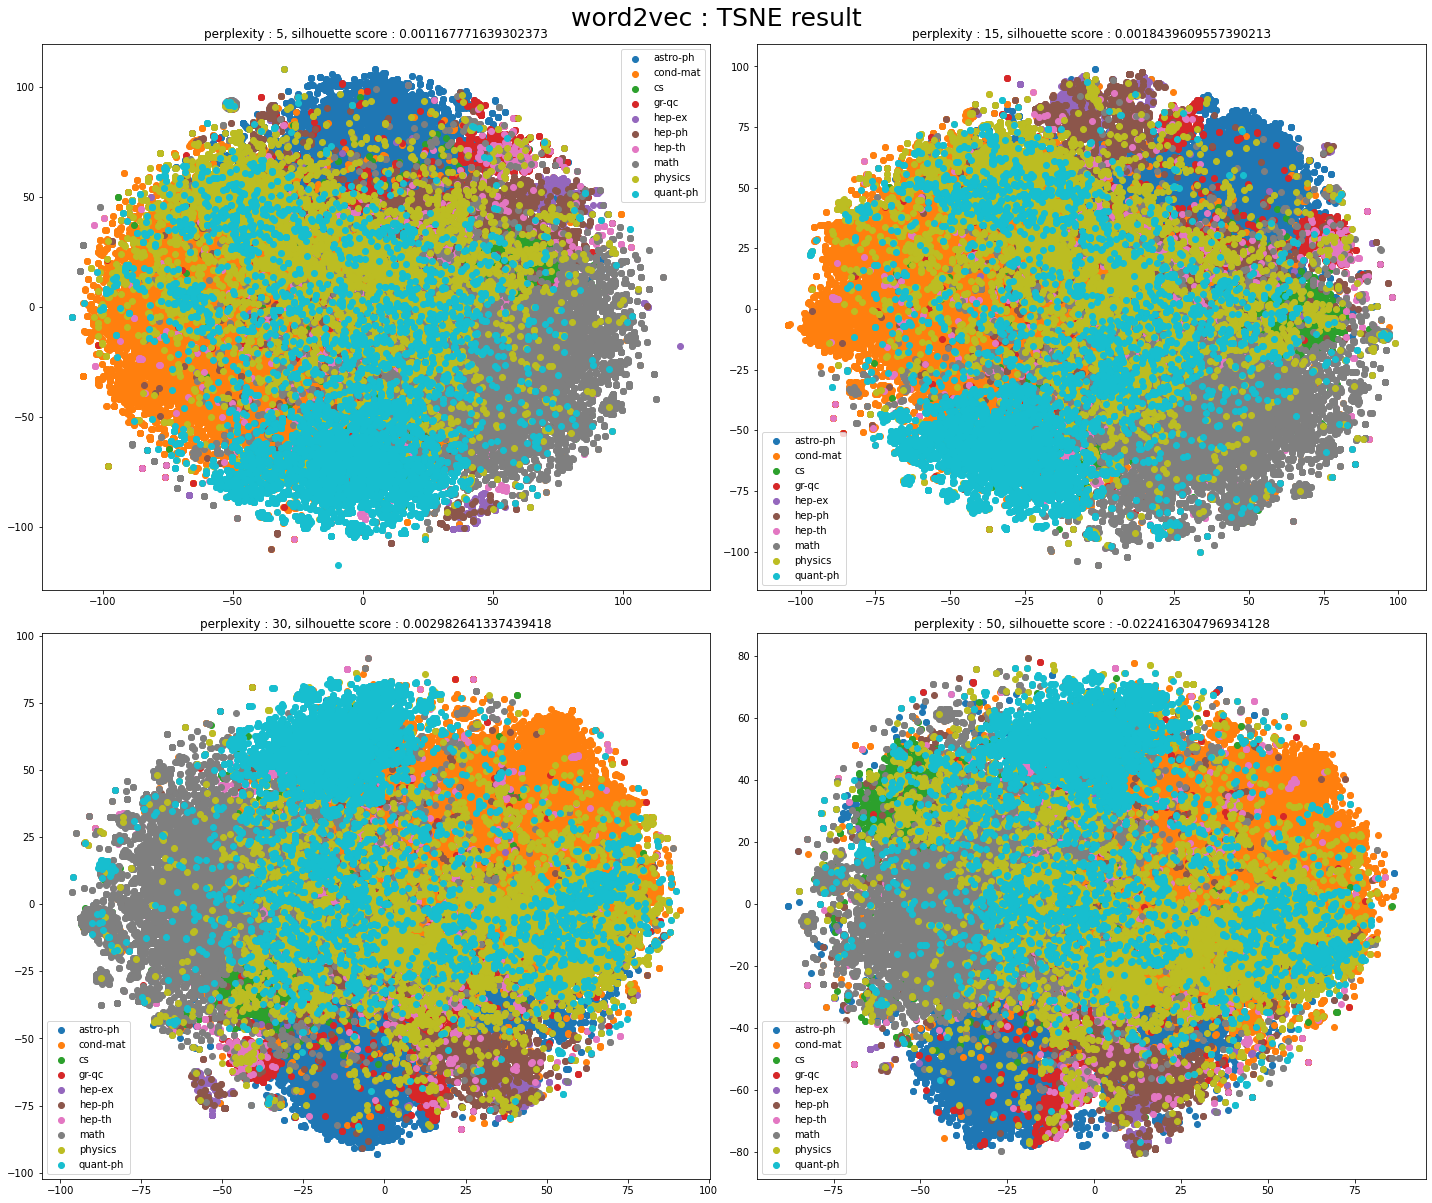

In [56]:
search_space = [5, 15, 30, 50]
fig, ax = plt.subplots(2,2, figsize = (20,17))

i = 0
for hp in tqdm(search_space):
    reduced = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 42, perplexity = hp).fit_transform(W2V_ev_avg)
    for idx, c in enumerate(le.classes_):
        ax[i//2, i%2].scatter(reduced[labels == idx, 0], reduced[labels == idx, 1], label = c, color = plt.cm.tab10(idx))
    ax[i//2, i%2].set_title(f'perplexity : {hp}, silhouette score : {silhouette_score(reduced, labels)}')
    ax[i//2, i%2].legend()
    i = i + 1
plt.suptitle('word2vec : TSNE result', fontsize = 25)
plt.tight_layout()
plt.show()

<h3>fastText</h3>

In [57]:
from gensim.models.keyedvectors import KeyedVectors
model = KeyedVectors.load_word2vec_format('cc.en.300.vec.gz')

In [63]:
def ft_preprocess(x):
    temp = []
    for word in x:
        try:
            temp.append(model.get_vector(word))
        except:
            pass
    if len(temp) == 0:
        return [0 for _ in range(300)]
    else:
        return np.mean(temp, axis = 0)
    
FT_ev_avg = title.apply(ft_preprocess)

In [64]:
FT_ev_avg = np.array([x for x in FT_ev_avg])
FT_ev_avg

array([[-0.012675  ,  0.014125  ,  0.02535   , ...,  0.0414    ,
        -0.016     ,  0.01995   ],
       [-0.00718   , -0.0309    ,  0.02734   , ...,  0.0642    ,
         0.00788   ,  0.01014   ],
       [-0.02595   , -0.01945   ,  0.0359625 , ...,  0.0594375 ,
        -0.013675  , -0.0025875 ],
       ...,
       [-0.02615   , -0.00608333,  0.02448333, ...,  0.06568334,
        -0.01676667, -0.01013333],
       [-0.02635   ,  0.0091    ,  0.01345   , ...,  0.1041    ,
        -0.00965   , -0.08585   ],
       [-0.00744286, -0.0093    , -0.02594286, ...,  0.09277143,
        -0.00735714, -0.01038571]])

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [30:33<00:00, 458.39s/it]


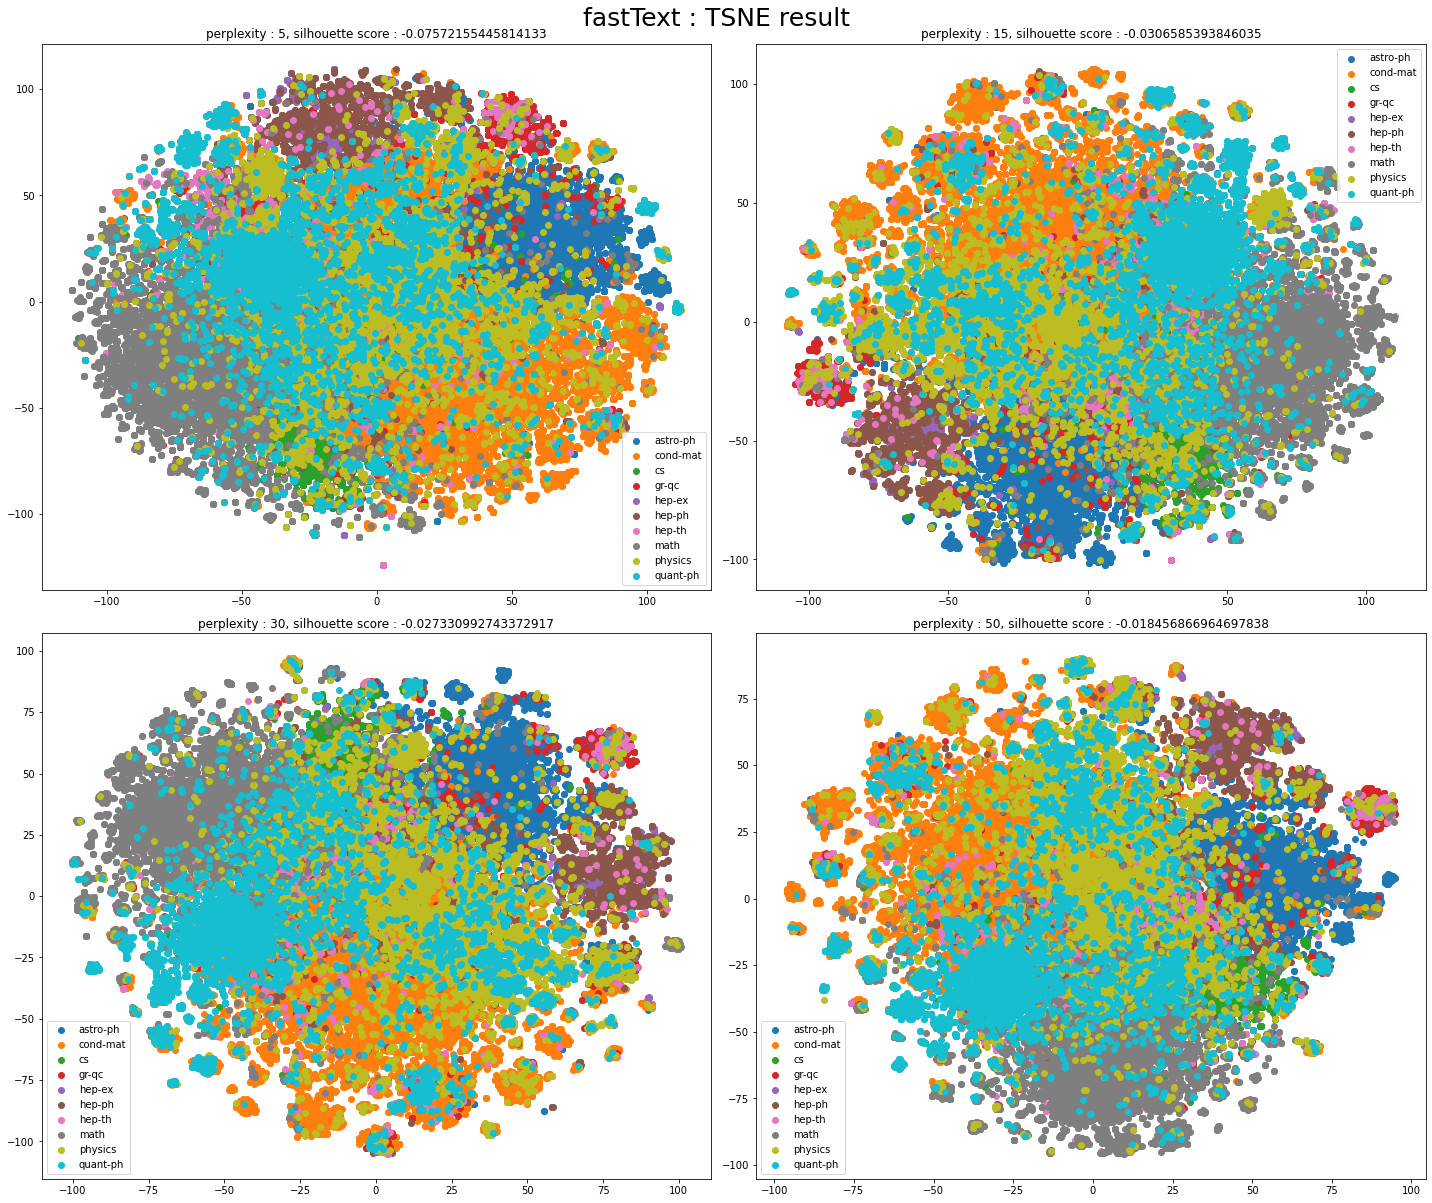

In [65]:
search_space = [5, 15, 30, 50]
fig, ax = plt.subplots(2,2, figsize = (20,17))

i = 0
for hp in tqdm(search_space):
    reduced = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 42, perplexity = hp).fit_transform(FT_ev_avg)
    for idx, c in enumerate(le.classes_):
        ax[i//2, i%2].scatter(reduced[labels == idx, 0], reduced[labels == idx, 1], label = c, color = plt.cm.tab10(idx))
    ax[i//2, i%2].set_title(f'perplexity : {hp}, silhouette score : {silhouette_score(reduced, labels)}')
    ax[i//2, i%2].legend()
    i = i + 1
plt.suptitle('fastText : TSNE result', fontsize = 25)
plt.tight_layout()
plt.show()

<h3>glove</h3>

In [74]:
embedding_dict = dict()

f = open('glove.6B.300d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]

    # 100개의 값을 가지는 array로 변환
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    embedding_dict[word] = word_vector_arr
f.close()

In [75]:
def glove_preprocess(x):
    temp = []
    for word in x:
        try:
            temp.append(embedding_dict[word])
        except:
            pass
    if len(temp) == 0:
        return [0 for _ in range(300)]
    else:
        return np.mean(temp, axis = 0)
    
glove_ev_avg = title.apply(glove_preprocess)
del(embedding_dict)

In [76]:
glove_ev_avg = np.array([x for x in glove_ev_avg])
glove_ev_avg

array([[ 0.04645214,  0.1139944 ,  0.13150911, ...,  0.077272  ,
         0.02359121,  0.10115011],
       [ 0.26923081,  0.3242164 ,  0.0111408 , ..., -0.148066  ,
         0.61712605,  0.01978999],
       [ 0.0596955 ,  0.16604875, -0.14882837, ..., -0.01750875,
         0.22239275, -0.08754275],
       ...,
       [-0.15550584,  0.20167148, -0.02403333, ..., -0.1220325 ,
         0.57003504, -0.0243565 ],
       [-0.02933   , -0.23339249,  0.115765  , ..., -0.47375   ,
         0.01569499,  0.37585115],
       [-0.22890285,  0.25488171,  0.050851  , ..., -0.14802043,
        -0.14316328, -0.33693573]])

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [31:49<00:00, 477.33s/it]


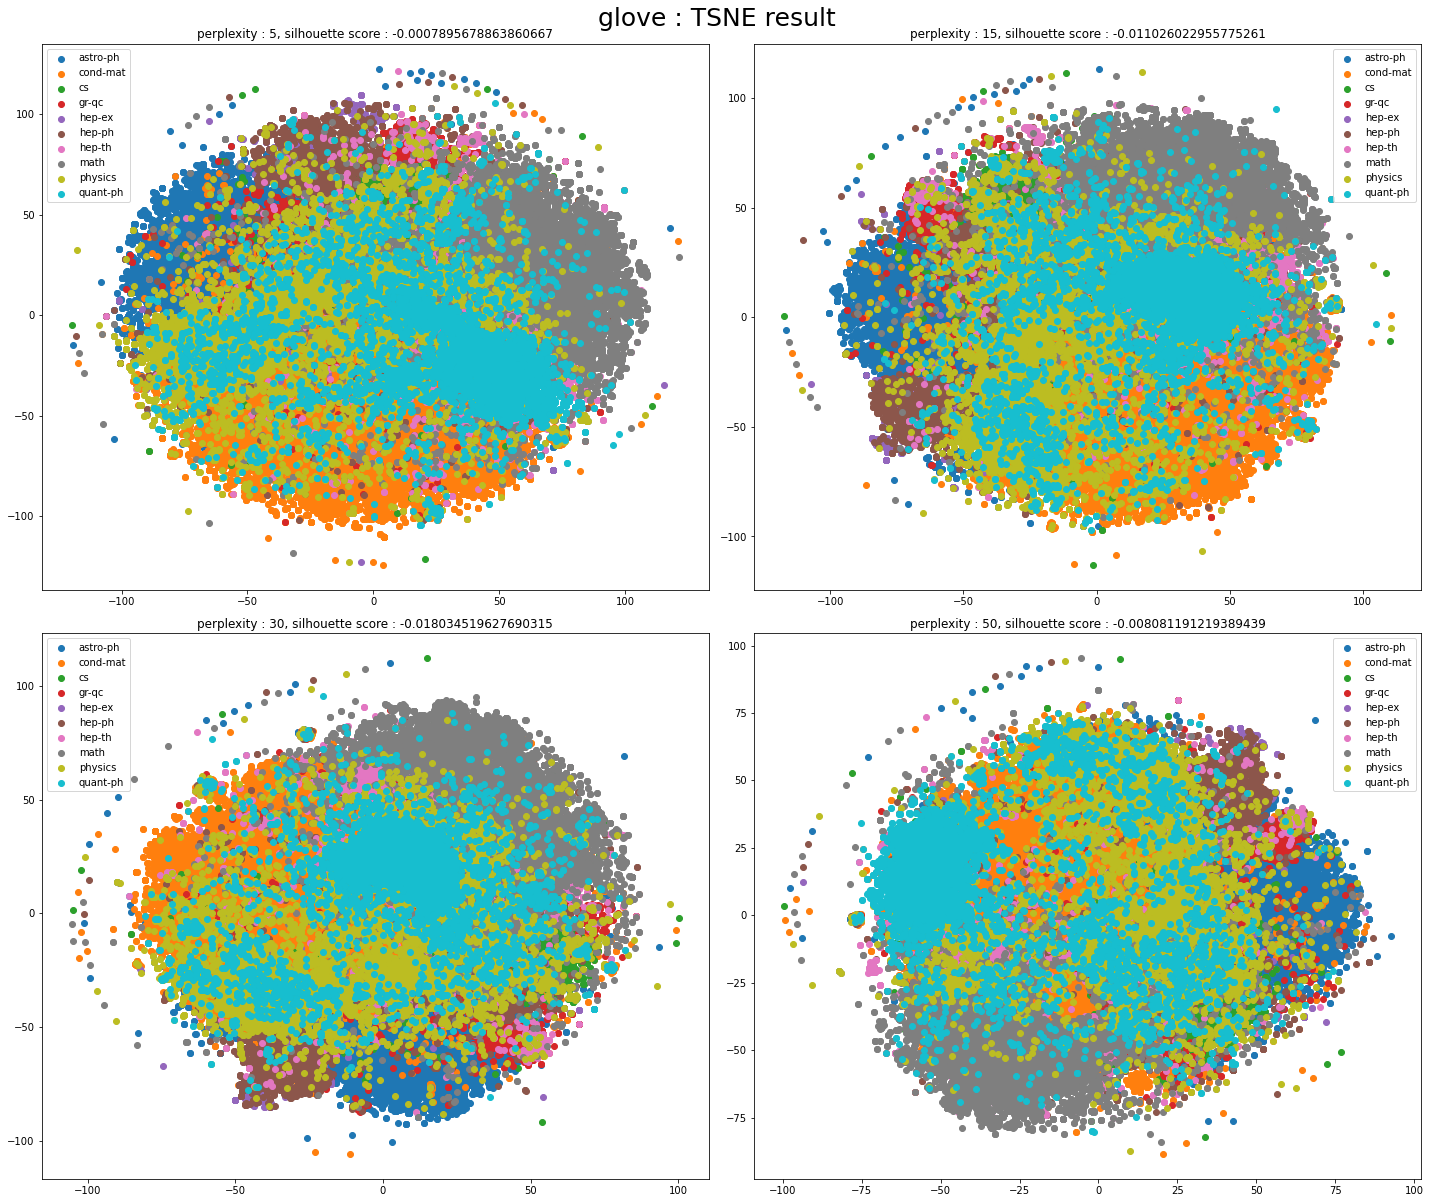

In [77]:
search_space = [5, 15, 30, 50]
fig, ax = plt.subplots(2,2, figsize = (20,17))

i = 0
for hp in tqdm(search_space):
    reduced = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 42, perplexity = hp).fit_transform(glove_ev_avg)
    for idx, c in enumerate(le.classes_):
        ax[i//2, i%2].scatter(reduced[labels == idx, 0], reduced[labels == idx, 1], label = c, color = plt.cm.tab10(idx))
    ax[i//2, i%2].set_title(f'perplexity : {hp}, silhouette score : {silhouette_score(reduced, labels)}')
    ax[i//2, i%2].legend()
    i = i + 1
plt.suptitle('glove : TSNE result', fontsize = 25)
plt.tight_layout()
plt.show()

<h3>BERT</h3>